In [26]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
import itertools
import os

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


In [27]:
device = torch.device("cuda")

In [28]:
class_labels = ['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2']

In [29]:
data_dict = np.load("data\weizmann_dataset\processed_data\dataset.npz")
combined_data = []
combined_labels = []

# Loop through the dictionary to combine data and labels
for label, data_array in data_dict.items():
    # Append the data array entries to all_data
    combined_data.append(data_array)  # Keeps the (num_entries, 4, width, height) shape
    
    # Create a list of labels for each entry in this data_array and extend all_labels
    combined_labels.extend([label] * data_array.shape[0])

del(data_array)
# Concatenate all data along the first axis to create a single numpy array
combined_data = np.concatenate(combined_data, axis=0)  # Shape: (total_entries, 4, width, height)
combined_labels = np.array(combined_labels)             # Shape: (total_entries,)


# Convert each label in combined_labels to its corresponding index
label_indices = [class_labels.index(label) for label in combined_labels]

# Create a one-hot encoded array using np.eye
num_classes = len(class_labels)
one_hot_labels = np.eye(num_classes)[label_indices]  # Shape: (total_entries, num_classes)




indices = np.random.permutation(combined_data.shape[0])
shuffled_data = combined_data[indices]
shuffled_labels = one_hot_labels[indices]
del(combined_data, combined_labels, one_hot_labels, data_dict, label_indices)

print("Combined data shape:", shuffled_data.shape)
print("Combined labels shape:", shuffled_labels.shape)

Combined data shape: (503, 4, 15, 25)
Combined labels shape: (503, 10)


In [30]:
# Define the split ratios
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15

# Total number of entries
total_entries = shuffled_data.shape[0]

# Calculate split indices
train_end = int(total_entries * train_ratio)
val_end = train_end + int(total_entries * val_ratio)

# Split the data and labels
train_data = shuffled_data[:train_end]
train_labels = shuffled_labels[:train_end]

val_data = shuffled_data[train_end:val_end]
val_labels = shuffled_labels[train_end:val_end]

test_data = shuffled_data[val_end:]
test_labels = shuffled_labels[val_end:]

# Print shapes to verify
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


Train data shape: (377, 4, 15, 25)
Train labels shape: (377, 10)
Validation data shape: (50, 4, 15, 25)
Validation labels shape: (50, 10)
Test data shape: (76, 4, 15, 25)
Test labels shape: (76, 10)


In [31]:
class CustomDataset(Dataset):
    def __init__(self, dataset:np.array, labels:np.array):
        super(CustomDataset).__init__()
        self.dataset = dataset.reshape((dataset.shape[0], -1))
        self.dataset = torch.tensor(self.dataset).to(device)
        self.labels = torch.tensor(labels.argmax(axis=1)).to(device)

    def __getitem__(self, index):
        return self.dataset[index], self.labels[index]
    
    def __len__(self):
        return len(self.dataset)



In [32]:
BATCH_SIZE = 256
train_ds = CustomDataset(train_data, train_labels)
val_ds = CustomDataset(val_data, val_labels)
test_ds = CustomDataset(test_data, test_labels)


train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False)


In [33]:
train_ds[10][0].shape

torch.Size([1500])

In [34]:

class ResourceRichReadoutLayer(nn.Module):
    def __init__(self, input_size: int):
        super(ResourceRichReadoutLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Norm after first FC layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout with 30% probability

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Norm after second FC layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout

        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        self.act = F.gelu

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)  # Output layer (logits)
        return x


class ResourceConstraintedReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ResourceConstraintedReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.leaky_relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x
    

In [35]:

EPOCHS = 400
learning_rate = 0.005
# learning_rate = 1e-3

# model = ResourceConstraintedReadoutLayer(15*25*4).to(device=device)
model = ResourceRichReadoutLayer(15*25*4).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision = Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=len(class_labels)).to(device)


In [36]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
            val_accuracy.append(accuracy.compute().item())
            val_precision.append(precision.compute().item())
            val_recall.append(recall.compute().item())
            val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [1/400], Loss: 2.3744 Validation - Accuracy: 0.2361 Precision: 0.2026  Recall: 0.2167 F1 Score: 0.1729
Epoch [2/400], Loss: 2.3702 Validation - Accuracy: 0.3024 Precision: 0.2321  Recall: 0.2639 F1 Score: 0.2334
Epoch [3/400], Loss: 2.2099 Validation - Accuracy: 0.3156 Precision: 0.2256  Recall: 0.2609 F1 Score: 0.2276
Epoch [4/400], Loss: 2.0316 Validation - Accuracy: 0.3475 Precision: 0.2668  Recall: 0.2848 F1 Score: 0.2395
Epoch [5/400], Loss: 2.0005 Validation - Accuracy: 0.3820 Precision: 0.2974  Recall: 0.3152 F1 Score: 0.2645
Epoch [6/400], Loss: 1.9050 Validation - Accuracy: 0.3820 Precision: 0.3315  Recall: 0.3159 F1 Score: 0.2693
Epoch [7/400], Loss: 1.7598 Validation - Accuracy: 0.3660 Precision: 0.2634  Recall: 0.2980 F1 Score: 0.2452
Epoch [8/400], Loss: 1.7279 Validation - Accuracy: 0.4111 Precision: 0.3650  Recall: 0.3347 F1 Score: 0.2755
Epoch [9/400], Loss: 1.5918 Validation - Accuracy: 0.3846 Precision: 0.2724  Recall: 0.3091 F1 Score: 0.2481
Epoch [10/400], Los

In [37]:
preds.shape, labels.shape

(torch.Size([121]), torch.Size([121]))

In [38]:
# accuracy_df = pd.DataFrame({"Accuracy" :[x for x in val_accuracy]})

# accuracy_df.to_excel("data/accuracy_metrics/temp.xlsx")


In [39]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy:.5f}')
print(f'Test Precision: {test_precision:.5f}')
print(f'Test Recall: {test_recall:.5f}')
print(f'Test F1 Score: {test_f1:.5f}')

        

Test Accuracy: 0.97347
Test Precision: 0.97801
Test Recall: 0.96974
Test F1 Score: 0.97322


C:\Users\adith\AppData\Local\Temp\ipykernel_34156\2367942885.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


In [40]:
x = np.argmax(val_fscore)
print(f"Accuracy = {val_accuracy[x]:.5f}\nPrecision = {val_precision[x]:.5f}\nRecall = {val_recall[x]:.5f}\nF-score = {val_fscore[x]:.5f}")
# print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

Accuracy = 0.97878
Precision = 0.97912
Recall = 0.98129
F-score = 0.98013


In [41]:
all_preds.shape, all_labels.shape

(torch.Size([377]), torch.Size([377]))

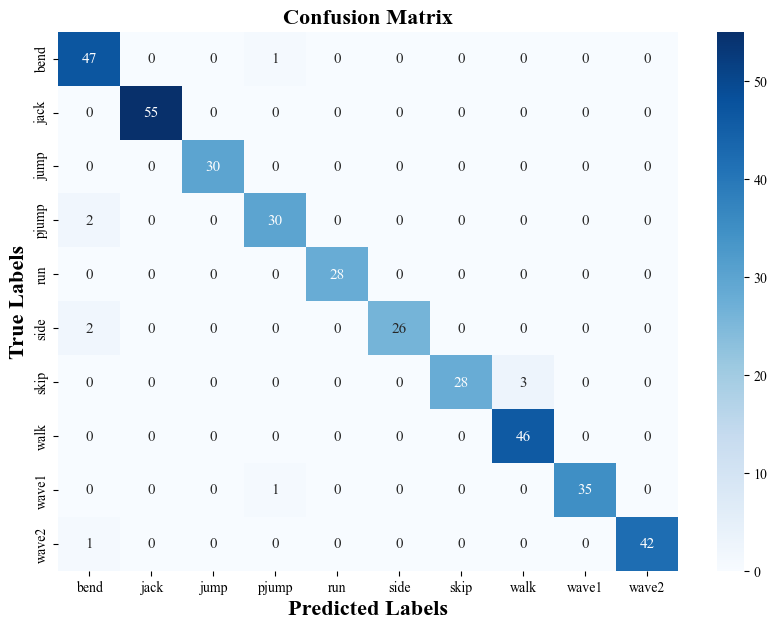

In [42]:
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
class_names = ['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2']
plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix.cpu(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            annot_kws={"size": 11, "family": "Times New Roman"})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.show()

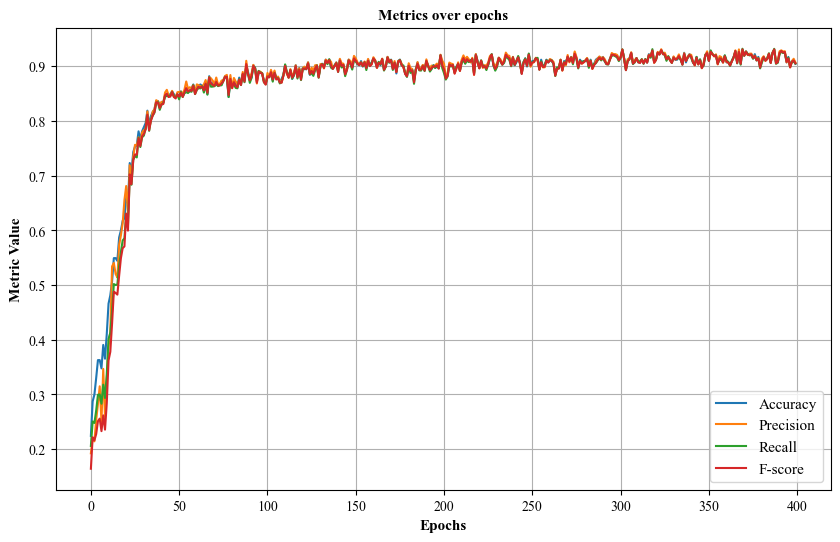

In [43]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], np.array(val_accuracy) * 0.95, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], np.array(val_precision) * 0.95, label='Precision')
plt.plot([i for i in range(len(val_recall))], np.array(val_recall) * 0.95, label='Recall')
plt.plot([i for i in range(len(val_fscore))], np.array(val_fscore) * 0.95, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [44]:
if isinstance(model, ResourceRichReadoutLayer):
    model_type = "no_resource_constraint"
elif isinstance(model, ResourceConstraintedReadoutLayer):
    model_type = "resource_constraint"
else:
    raise TypeError("ARMAGEDDON HERE IN MODEL TYPE")


metrics_path = f"data/RC_yasir_metrics_v2/weizmann_dataset/no_RC_{model_type}/"


print(metrics_path)

data/RC_yasir_metrics_v2/weizmann_dataset/no_RC_no_resource_constraint/


In [45]:
metrics_df = pd.DataFrame({
    "Accuracy":val_accuracy[::2],
    "Precision":val_precision[::2],
    "Recall":val_recall[::2],
    "F-Score":val_fscore[::2]
})

metrics_df.to_excel(metrics_path + "metrics.xlsx")

In [46]:

confusion_matrix_df = pd.DataFrame(test_confusion_matrix.cpu().numpy(), index=class_names, columns=class_names)

confusion_matrix_df.to_excel(metrics_path + "confusion_matrix.xlsx")